# Final Project DL model Notebook - linear model - v03

#### imports, settings and constants

In [1]:
import sys

from keras.models import Sequential
from keras.layers import BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
from keras import regularizers

import numpy as np

from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import *

current_dir = Path.cwd()
HOME_DIR = current_dir.parent
DATA_DIR = HOME_DIR.joinpath('data')

# comment out one of the two path options to toggle between sample directory and all data
# path = DATA_HOME_DIR
path = DATA_DIR.joinpath('sample')
train_path = path.joinpath('train')
val_path = path.joinpath('valid')
test_path = path.joinpath('test')
results_path = path.joinpath('tesults')

# training variables
batch_size = 6
epochs = 2
learning_rate = 1e-3
regularization_rate = 0.01

Using Theano backend.


#### getting training and validation data in batches

In [2]:
batches = get_in_batches(train_path, batch_size=batch_size)
val_batches = get_in_batches(val_path, batch_size=batch_size)
test_batches = get_in_batches(test_path, batch_size=batch_size)

Found 1000 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


#### and getting the classes, labels and filenames for each batch

In [3]:
trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(batches.classes)
val_labels = onehot(val_batches.classes)
trn_filenames = batches.filenames
val_filenames = val_batches.filenames

#### defining linear model - same as v02, but with l2 regularisation

In [4]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(regularization_rate))
    ])
model.compile(Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 224, 224)       12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1505290   
Total params: 1,505,302
Trainable params: 1,505,296
Non-trainable params: 6
_________________________________________________________________


#### fit_generator() consuming the batches provided by the ImageDataGenerator to fit the model to the data

In [5]:
history = model.fit_generator(batches,
                    steps_per_epoch=batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=val_batches.batch_size,
                    epochs=epochs)

Epoch 1/2
6/6 [==============================] - 1s - loss: 11.8932 - acc: 0.1389 - val_loss: 15.5723 - val_acc: 0.0556
Epoch 2/2
6/6 [==============================] - 1s - loss: 15.6286 - acc: 0.0556 - val_loss: 15.2475 - val_acc: 0.0833


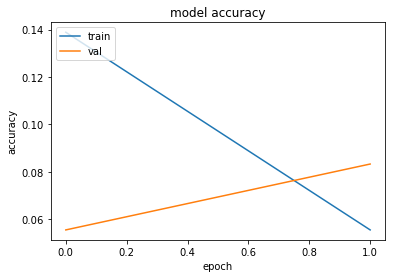

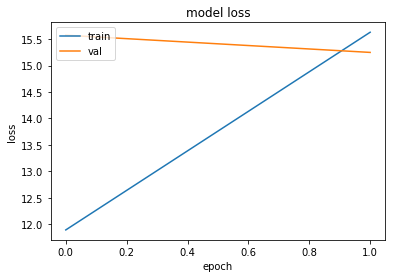

In [6]:
plot_acc_and_loss(history)

#### validating the model performance on the val set

In [7]:
rnd_batches = get_in_batches(val_path, batch_size=batch_size*2, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(epochs)]
np.round(val_res, 3)

Found 200 images belonging to 10 classes.


array([[ 14.781,   0.109],
       [ 14.744,   0.111]])

#### test performance and plot confusion matrix on one batch of 200 images

In [8]:
test_set = get_in_batches(val_path, shuffle=False, class_mode=None, batch_size=200)
pred_classes = model.predict_generator(test_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = test_set.classes

Found 200 images belonging to 10 classes.


[[ 0  0  0  8  0  0  0  0  0 12]
 [ 0  0  0  8  0  0  5  0  0  7]
 [ 0  0  0  4  0  0  8  0  0  8]
 [ 0  0  0 10  0  0  2  0  0  8]
 [ 0  0  0  3  0  0  8  0  0  9]
 [ 0  0  0 10  0  0  2  0  0  8]
 [ 0  0  0  8  0  0  6  0  0  6]
 [ 0  0  0 10  0  0  3  0  0  7]
 [ 0  0  0  7  0  0  5  0  0  8]
 [ 0  0  0  8  0  0  6  0  0  6]]


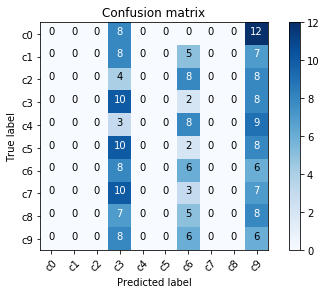

In [9]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()